In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
import mmh3
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
from IPython.display import display, clear_output
from joblib import Parallel, delayed

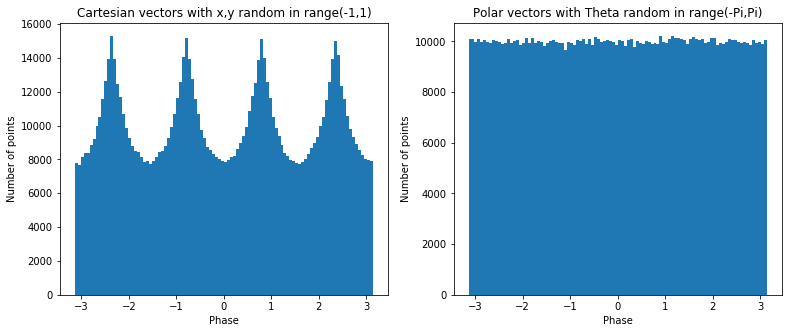

In [2]:
# Problem 1
def generate_pnts(n,typ='undefined'):
    for i in range(n):
        if typ.lower() == 'polar':
            yield 1, (random.random()*2-1)*math.pi
        elif typ.lower() == 'cartesian':
            x=random.random()*2-1
            y=random.random()*2-1
            yield x/(x**2+y**2)**0.5,y/(x**2+y**2)**0.5
        else:
            print('point type %s' % (typ.lower()))
cartesdataP=[]
polardataP=[]
delta=0.001
bins=100
n=1000000

polardataP=[p[1] for p in generate_pnts(n,'polar')]
cartesdataP=[math.atan2(p[0],p[1]) for p in generate_pnts(n,'cartesian')]


plt.figure(1, figsize=(20, 5))

plt.subplot(131)
plt.hist(cartesdataP,bins)
plt.title('Cartesian vectors with x,y random in range(-1,1)')
plt.xlabel('Phase')
plt.ylabel('Number of points')

plt.subplot(132)
plt.hist(polardataP,bins)
plt.title('Polar vectors with Theta random in range(-Pi,Pi)')
plt.xlabel('Phase')
plt.ylabel('Number of points')

plt.show()


# Problem 2


From each machine $M_i, i\leq t$, take a small random sample $\hat d_i$ of the data available to the machine, call it $d_i$, and send it to some fixed node $M_0$. $M_0$ receives samples from each machine and based on their union is able to obtain an estimate, call it $\hat D$, of the distribution of the whole dataset $D$. $M_0$ then computes bin sizes such that approximately equal amounts of data from $\hat D$ fall into each bucket (total $t$ buckets) and distributes this information across the $t$ machines. Each machine $M_i$ then should apply this bucketing as computed by $M_0$ to the full $d_i$ available to it and create key-value pairs with keys equal to bucket id's and values being the data elements.

In [ ]:
# Problem 3

# Part 1


def mk_sample(n):
    sample = []
    indeces = []
    while len(indeces)<n:
        k = int(random.random()*population)
        if k not in indeces: indeces.append(k)

    for i, line in enumerate(tqdm(fp,total=1000000)):
        if i in indeces: sample.append(parsed(line))
        else: pass
        if len(sample)==n:
            fp.close()
            break
    return sample

def js(s1,s2):
    I=sum([1 for item in s1 if item in s2])
    U=len(s1)+len(s2)-I
    return I/U

def parsed(seq):
    return [int(item) for item in seq.strip().split(' ')]

def minhash(elem_set,i):
    val = float('inf')
    for item in elem_set:
        new = mmh3.hash(str(item)+str(i))
        if new < val: val = new
    return val

def signature(elem_set,k):
    return [minhash(elem_set,i) for i in range(k)]

def G(band):
    return mmh3.hash(band)

def proc(raw,r,b):
    j=0
    band = ''
    sign = []
    for elem in raw:
        if j%r == 0 and j!=0:
            sign.append(band)
            band=''
        band +=str(elem)
        j+=1
    sign.append(band)
    return sign

def dress_signature(line,k,i):
    line = parsed(line)
    return (line,proc(signature(line,k),r,b),i)


def proc_batch(batch,k):
#     print(len(batch))
    return [dress_signature(line,k,i) for i, line in enumerate(batch)]

def convert_to_signatures(filename,r,b):
    signatures = []    
    k = r*b
    start=time.time()
    with open(filename,'r') as fp:
        fp_read = fp.readlines()
        n_jobs=8
        batch_size = int(len(fp_read)/n_jobs)
        fp_read = [fp_read[n:n+batch_size] for n in range(0,len(fp_read),batch_size)]

    signatures = Parallel(n_jobs=n_jobs)(delayed(proc_batch)(batch,k) for batch in fp_read)
    signatures = [item for sublist in signatures for item in sublist]
   
    end=time.time()

    print('generating signatures took',round((end-start)/60,2),'minutes.')
    return signatures

def compare_band(signatures,i):
    band_collisions = []
    candidates = {}
    for set_sign_linum in tqdm(signatures):
        candidate = G(set_sign_linum[1][i])
        if str(candidate) in candidates:
            this_set = (set_sign_linum[0], set_sign_linum[2])
            similar_set = (candidates[str(candidate)])
            band_collisions.append((this_set, similar_set))
#             clear_output(wait=True)
#             display('number of collisions: '+str(len(band_collisions)))
        else:
            candidates[str(candidate)]=(set_sign_linum[0],set_sign_linum[2])
    return band_collisions
    
def compare_bands(signatures,b):
#     print('there will be %d processes of equal duration' % b)
    collisions = []
    i=0
    start=time.time()       
    
#     bands=Parallel(n_jobs=7)(delayed(compare_band)(signatures,i) for i in tnrange(b))
    bands=[compare_band(signatures,i) for i in tnrange(b)]
    collisions = [match for collection in bands for match in collection]
    
    end=time.time()
    print('comparing bands took',(end-start)/60,'minutes.')
    return collisions
# 
def confirm_js(collisions):
    true_cols = []
    line_nums={}
    for col in tqdm(collisions):
        simil = js(col[0][0],col[1][0])
        if simil >=0.85:
            print('BINGO')
            print(js(col[0][0],col[1][0]))
            print(col[0][1])
            print(col[1][1])
            true_cols.append(col)
            line_nums[col[0][1]] = (col[0][0],col[1][0])
            line_nums[col[1][1]] = (col[0][0],col[1][0])
            clear_output(wait=True)
            display('number of similar sets:'+str(len(true_cols)))
    return true_cols

In [6]:
fp = open('data.txt','r')
prev_line=parsed(fp.readline())
n=0
limit = 5000


start = time.time()

for line in fp:
    new_line=parsed(line)
    js(new_line,prev_line)
    prev_line=new_line
    n+=1
    if n>limit:break

end = time.time() # 5000 pairs

print ('days required to run the full job:',(end - start)*99999900/60/60/24)
    
fp.close()

# 912 days with direct JS on 10^6 choose 2 pairs

days required to run the full job: 912.3679371029139


In [8]:
population = 1000000
r=10
b=5
fp = open('data.txt','r')
sp = open('sample.txt','w')
print('taking a sample of data...')

sample_size = 500

start = time.time()
sample = mk_sample(sample_size) # 5000 samples is too slow (takes several minutes to compute anything)
end = time.time()
for line in sample:
    sp.write(' '.join(str(x) for x in line)+'\n')
sp.close()

print('taking a sample of size %d took %d seconds' % (sample_size,(end-start)))
fp.close()

sample_similarities=[0]*sample_size
i=0

start = time.time()
for item in tqdm(sample):
    i+=1
    for jtem in sample[i:]:
        simil = js(item,jtem)//0.001
        sample_similarities[int(simil)] += 1
end = time.time()


print('computing similarities for the sample directly took',end-start,'seconds')
print ('running the full job directly would take',round((end - start)*4008012/60/60/24),'days')

print('\ntesting all functions on the sample...')
signatures = convert_to_signatures('sample.txt',r,b)
collisions = compare_bands(signatures,b)

taking a sample of data...
taking a sample of size 500 took 9 seconds



computing similarities for the sample directly took 19.71661686897278 seconds
running the full job directly would take 915 days

testing all functions on the sample...
generating signatures took 0.02 minutes.



comparing bands took 0.0031589468320210776 minutes.


max gradient             at JS = 0.8997
P(collision)      at JS >= 0.85: 0.4227
threshold:  0.905      b = 3 r = 11 k = 33


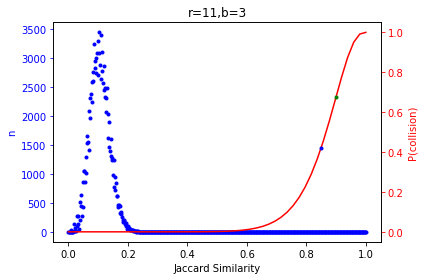

In [10]:
rbvals085 = [(11,3),(13,8),(25,60)]
# 6,3 gives 0.3 hrs
# r=13, b=8 is better than r=25, b=60, but still too many calculations (104 hashes per set)
def fn(x):
    return 1-(1-x**r)**b

with open('sample.txt','r') as sample_fp:
    sample = [parsed(line) for line in sample_fp]
    
r,b=rbvals085[0]
k=r*b
x = np.linspace(0,1); f = fn(x); 
x_ = ((r-1)/(b*r-1))**(1/r)

print('max gradient             at JS =',round(x_,4))
print('P(collision)      at JS >= 0.85:',round(fn(0.85),4))
print('threshold: ',round((1/b)**(b/k),3), '     b =',b,'r =',r,'k =',k)

fig, ax1 = plt.subplots()
plt.title('r=%d,b=%d' % (r,b))


ax1.plot(np.linspace(0,1,sample_size), sample_similarities, 'b.')
ax1.set_ylabel('n', color='b')
ax1.tick_params('y', colors='b')
plt.xlabel('Jaccard Similarity')

ax2 = ax1.twinx()
ax2.plot(x, f, 'r-',x_,(1-(1-x_**r)**b),'g.',0.85,fn(0.85),'b.')
ax2.set_ylabel('P(collision)', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [9]:
signatures = convert_to_signatures('data.txt',r,b)
collisions = compare_bands(signatures,b)
print("number of collisions:",len(collisions))
true_cols = confirm_js(collisions)
print("number of similar sets:",len(true_cols))
for item in true_cols:
    print(item[0][1],item[1][1], round(js(item[0][0],item[1][0]),3))